In [154]:
# Load Pre-trained Model
# Example: Loading a PyTorch model
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

os.chdir("/Users/kaspervanderhorst/Desktop/thesis")
# Correctly resolve the src directory at the root of the project\
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Verify that src is in the Python path
print(f"Added {src_path} to Python path.")

# Import the model
from src.models.base_model import RRCNNDecomposer
from src.models.base_model import MultiScaleRRCNNDecomposer

# Specify the path to the saved model checkpoint
model_path = "/Users/kaspervanderhorst/Desktop/thesis/models/nonstationary_reconstruction_fr_energy_ordering.pth"
# Load the model
model = MultiScaleRRCNNDecomposer()  # Adjust parameters as per your model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

Added /Users/kaspervanderhorst/Desktop/src to Python path.


MultiScaleRRCNNDecomposer(
  (imf_extractors): ModuleList(
    (0-1): 2 x MultiScaleRRCNNLayer(
      (convs): ModuleList(
        (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=same)
        (1): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=same)
        (2): Conv1d(1, 16, kernel_size=(30,), stride=(1,), padding=same)
      )
      (relu): ReLU()
      (out_conv): Conv1d(48, 1, kernel_size=(1,), stride=(1,))
    )
  )
)

In [155]:
# Resolve the dataset path
dataset_path = "/Users/kaspervanderhorst/Desktop/thesis/src/data/data_storage/composite_signals_20250512T203403.npz"

# Load the dataset
data = np.load(dataset_path)
X = data['composite_signals']
y = data['components']  # Ground truth components

print(f"Loaded dataset with {X.shape[0]} samples.")

Loaded dataset with 10000 samples.


In [156]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 9000
Testing set size: 1000


In [157]:
# Make Predictions
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")

# Make predictions
with torch.no_grad():
    predictions = model(X_test_tensor)

print("Predictions shape:", predictions.shape)

Shape of X_test_tensor: torch.Size([1000, 1000])
Shape of X_test_tensor: torch.Size([1000, 1, 1000])
Predictions shape: torch.Size([1000, 2, 1000])


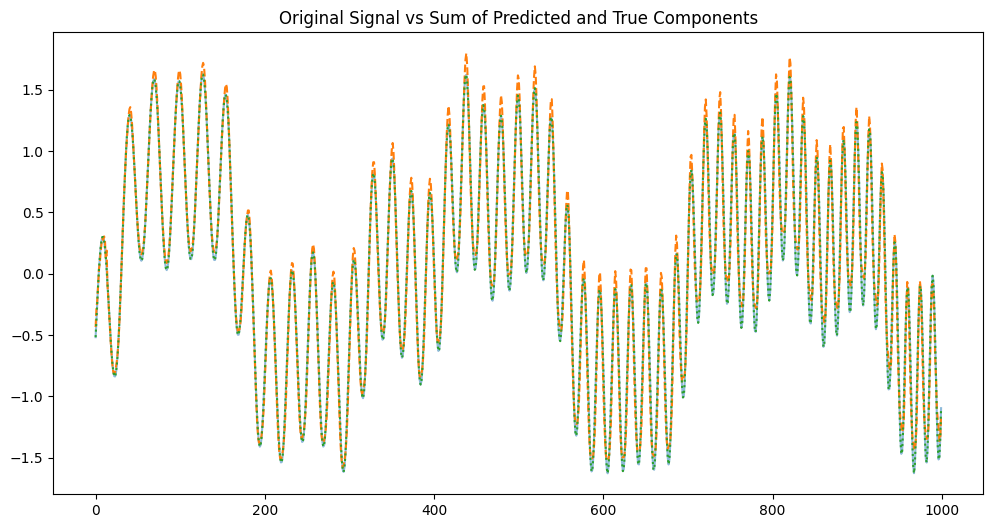

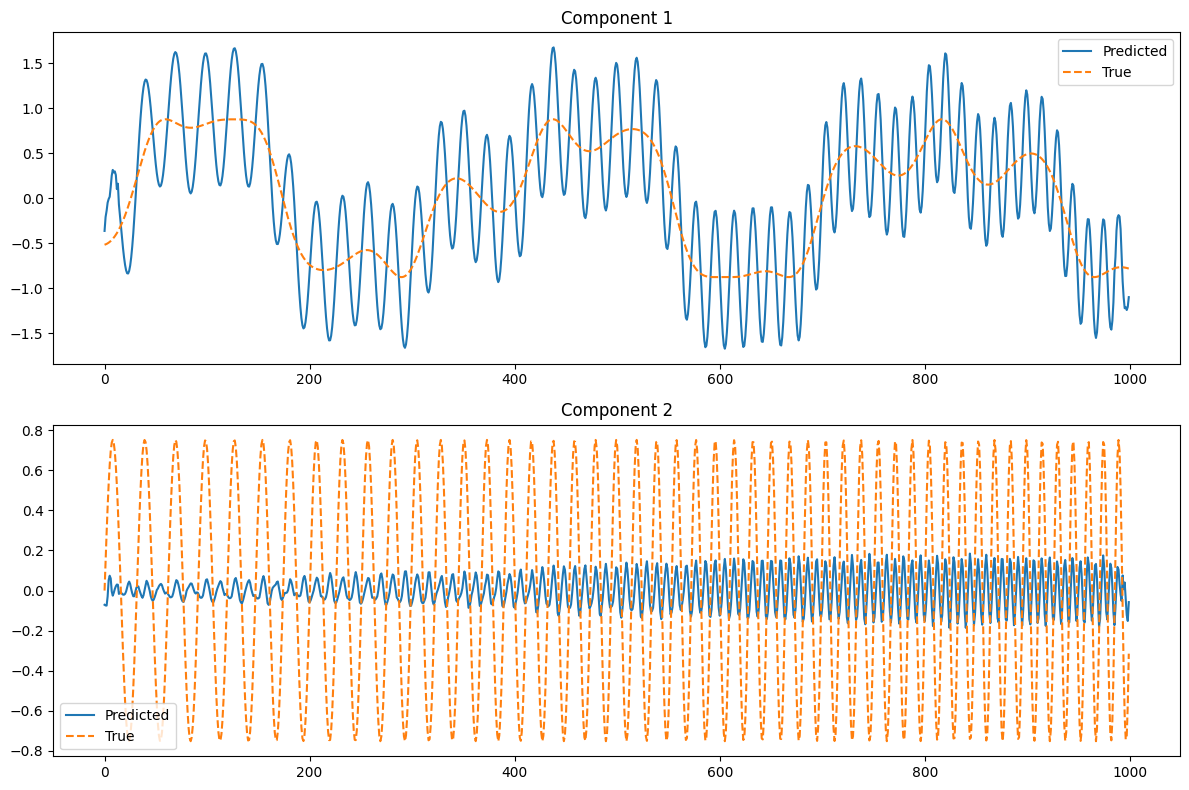

In [203]:
# Inspect Decompositions
# Visualize the decompositions predicted by the model and compare them to the ground truth

# Select a sample to visualize
sample_idx = 8
predicted_components = predictions[sample_idx].numpy()
true_components = y_test[sample_idx]

plt.figure(figsize=(12, 6))
plt.plot(X_test[sample_idx], label="Original Signal", alpha=0.5)
plt.plot(np.sum(predicted_components, axis=0), label="Sum of Predicted Components", linestyle="dashed")
plt.plot(np.sum(true_components, axis=0), label="Sum of True Components", linestyle="dotted")
plt.title("Original Signal vs Sum of Predicted and True Components")
# Plot the predicted and true components
num_components = predicted_components.shape[0]
plt.figure(figsize=(12, 8))
for i in range(num_components):
    plt.subplot(num_components, 1, i + 1)
    plt.plot(predicted_components[i], label="Predicted")
    plt.plot(true_components[i], label="True", linestyle="dashed")
    plt.title(f"Component {i + 1}")
    plt.legend()

plt.tight_layout()
plt.show()